### Exercise 1

Let $\theta_1$ and $\theta_2$ be real valued parameters of the model

$$
y = \frac{\theta_1 x}{\theta_2 + x}.
$$

a. Choose two suitable prior distributions for $\theta_1$ and $\theta_2$  and use HMC algorithm to find their posterior distributions, conditioning on the observations

$$
x=(28,55,110,138,225,375)\\
y=(0.053,0.060,0.112,0.105,0.099,0.122).
$$

In [410]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('ggplot')
import seaborn as sns
import torch
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC, HMC, NUTS
import pyro.poutine as poutine
np.set_printoptions(precision=4, suppress=True)

In [411]:
def model(x, dist: torch.distributions.Distribution):
    
    pyro.clear_param_store()
    # Suitable prior distribution with mean 0 and variance 1
    theta1 = pyro.sample("theta1", dist) 
    theta2 = pyro.sample("theta2", dist)
    
    # Calculated y variable
    y = pyro.param("y", (theta1*obs_x)/ (theta2+obs_x))
    print("theta1: {}, theta2: {}\nx: {}\ny: {}".format(theta1,theta2,x,y))
    
    return y

def conditioned_model(y, x,dist: torch.distributions.Distribution):

    pyro.clear_param_store()
    # Suitable prior distribution with mean 0 and variance 1
    theta1 = pyro.sample("theta1", dist) 
    theta2 = pyro.sample("theta2", dist)
    
    # Calculated y variable
    with pyro.plate(len(y)):
        y = pyro.param("y", (theta1*obs_x)/ (theta2+obs_x), obs = obs_y)
    
    return y

#model(obs_x, dist.Normal(0,1))
#conditioned_model(obs_y,obs_x,dist.Normal(0,1))

In [412]:
# @param model conditioned pyro model
# @param obs_y observations of y value
# @param obs_x observation of x value
# @param dist prior dist of theta1 and theta2 
# @param num_sample number of sample from stationary distribution
# @param warmup burn-in period, number of discarded samples before performing the actual sampling
# @param chain number of independent MCMC runs
# @return Progress bars of chains, summary of mcmc, lineplots of chains, dist plot of posterior
# P.S. This functions is written not to have code duplicates 
# for trying different parameters for mcmc algortihm and prior dist, that is why it is not that much generalize

def analyze_hmc(model,obs_y,obs_x,dist:torch.distributions.Distribution, num_sample, warmup, chain):
    
    '''This function runs HMC algorithm with given parameters 
    and plot the chain results and posterior distribution'''
    
    hmc_kernel = HMC(model=model) # transition kernel
    mcmc = MCMC(hmc_kernel, num_samples=num_sample, warmup_steps=warmup, num_chains=chain)

    # posteriors 
    posterior = mcmc.run(y = obs_y,x = obs_x, dist=dist)

    # dictionary of sampled values
    print("Keys:",mcmc.get_samples().keys(), "\n")

    print("Summary of MCMC:\n")

    mcmc.summary()
    
    mcmc_samples = mcmc.get_samples(group_by_chain=True)

    chains_1 = mcmc_samples["theta1"]
    chains_2 = mcmc_samples["theta2"]

    n_chains_1, n_samples_1 = chains_1.shape
    n_chains_2, n_samples_2 = chains_2.shape

    print("Shape of chain_1 {} and chain_2 {}\n".format(chains_1.shape, chains_2.shape))

    fig, ax = plt.subplots(1, n_chains_1, figsize=(12,3))
    for i, chain in enumerate(chains_1):
        sns.lineplot(x=range(n_samples_1), y=chain, ax=ax[i])
        ax[i].set_title("theta 1_chain "+str(i+1))

    fig, ax = plt.subplots(1, n_chains_2, figsize=(12,3))
    for i, chain in enumerate(chains_2):
        sns.lineplot(x=range(n_samples_2), y=chain, ax=ax[i])
        ax[i].set_title(" theta 2_chain "+str(i+1))
        
    
    print("expected theta1 =", mcmc_samples['theta1'].mean().item())
    print("expected theta2 =", mcmc_samples['theta2'].mean().item())

    fig,a = plt.subplots(1,2, figsize=(14,4))

    sns.distplot(mcmc_samples['theta1'], ax = a[0])
    a[0].set_title("P(theta1 | x = obs_x, y = obs_y)")
    a[0].set_xlabel("Theta1")

    sns.distplot(mcmc_samples['theta2'], ax = a[1])
    a[1].set_title("P(theta2 | x = obs_x, y = obs_y)")
    a[1].set_xlabel("Theta2")

- Chosen prior distributions for $\theta_1$ and $\theta_2$ are standard normal distribution. Chosen parameters for HMC are `num_samples = 500`,`warmup_steps = 1000` and `num_chains = 3`.

In [414]:
# observations
obs_y = torch.tensor([0.053,0.060,0.112,0.105,0.099,0.122])
obs_x = torch.tensor([(28,55,110,138,225,375)])




Keys: dict_keys(['theta1', 'theta2']) 

Summary of MCMC:


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    theta1      0.40      0.92      0.61     -1.48      1.58     11.43      1.23
    theta2     -0.04      0.75     -0.00     -1.16      0.96     16.76      1.13

Number of divergences: 0
Shape of chain_1 torch.Size([3, 500]) and chain_2 torch.Size([3, 500])

expected theta1 = 0.39602652192115784
expected theta2 = -0.041786473244428635


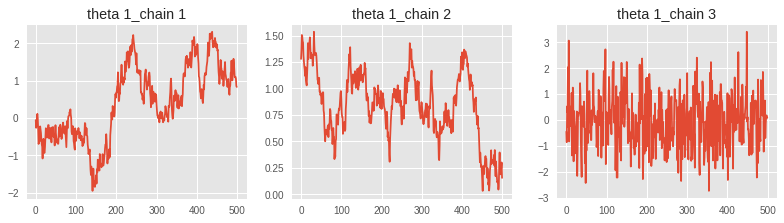

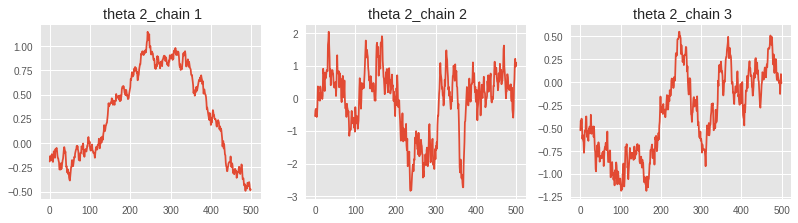

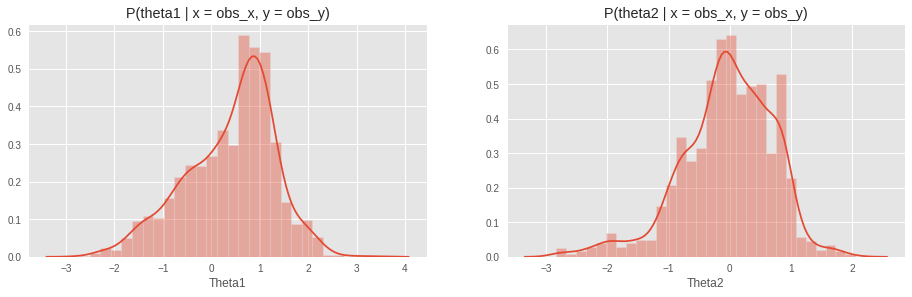

In [415]:
analyze_hmc(conditioned_model,obs_y,obs_x,dist.Normal(0,1),num_sample=500,warmup=1000,chain=3)

- There is no divergence in our hmc summary results but `n_eff` values are low and `r_hat` values are above 1 so we can say that some chains have not fully converged and above plots showed us that comment that is made before for `mcmc.summary` is true. Most of the chains are not consistent apart from theta1_chain 3. Also you can find the distributon of $P(\theta_1 | x ,y)$ and $P(\theta_2 | x ,y)$ as a result of MCMC algorithm

b. Discuss how different parameters for both priors and the HMC algorithm lead to different estimates. 

- Changing the parameters HMC algorithm may lead better estimates for posterior distribution. Especially increasing number of samples and number of chains may lead better estimations.

- Therefore parameters of mcmc algorithm are increased such as:  `num_samples = 1200`,`warmup_steps = 400` and `num_chains = 5`.






Keys: dict_keys(['theta1', 'theta2']) 

Summary of MCMC:


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    theta1      0.07      0.91      0.18     -1.55      1.52    793.87      1.01
    theta2     -0.21      1.04     -0.18     -2.10      1.36     46.68      1.08

Number of divergences: 0
Shape of chain_1 torch.Size([5, 1200]) and chain_2 torch.Size([5, 1200])

expected theta1 = 0.06781487911939621
expected theta2 = -0.21113228797912598


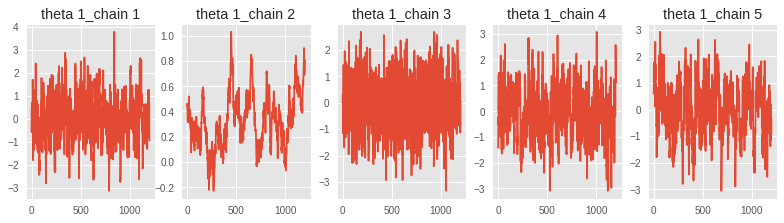

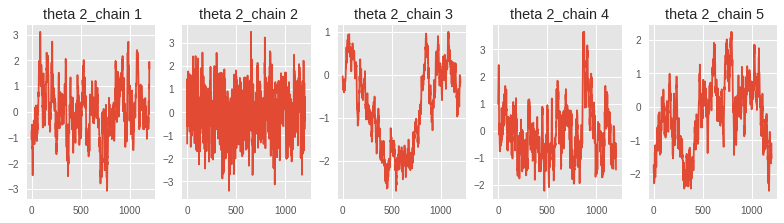

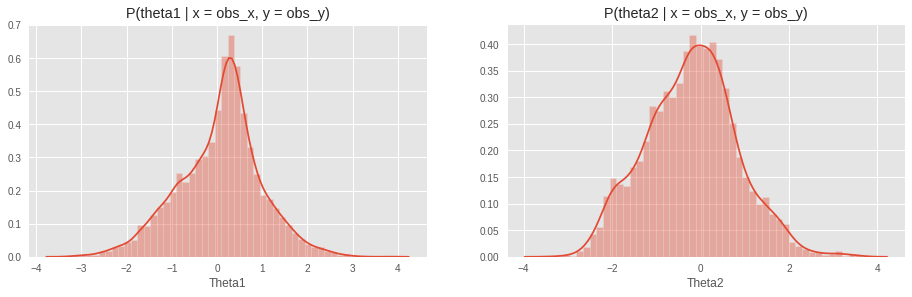

In [417]:
analyze_hmc(conditioned_model,obs_y,obs_x,dist.Normal(0,1),1200, 400, 5)

- For $\theta_1$, we have high `n_eff` and close value of `r_hat` to 1. And most of the chains are consistent and converged just the second one seems diverged. So we can say that we have good results for $\theta_1$. However for $\theta_2$ even though we can say that result are quite better than previous ones, it is not as good as $\theta_1$.

- Changing the parameters of prior distribution may lead better results. Therefore same analyze will be done for $\theta_k \sim \mathcal{N}(5,10)$ where $k = 1,2$






Keys: dict_keys(['theta1', 'theta2']) 

Summary of MCMC:


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    theta1      5.29      8.81      3.18     -8.25     20.96    103.12      1.05
    theta2      4.82      9.83      5.10    -11.33     20.52    757.27      1.00

Number of divergences: 0
Shape of chain_1 torch.Size([5, 1200]) and chain_2 torch.Size([5, 1200])

expected theta1 = 5.294678211212158
expected theta2 = 4.817432403564453


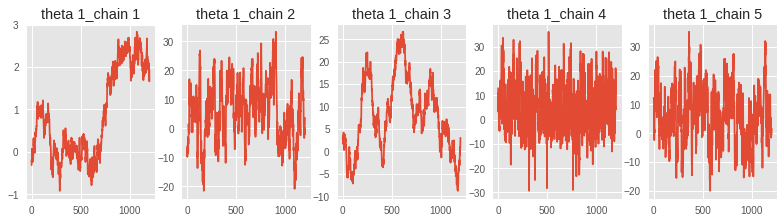

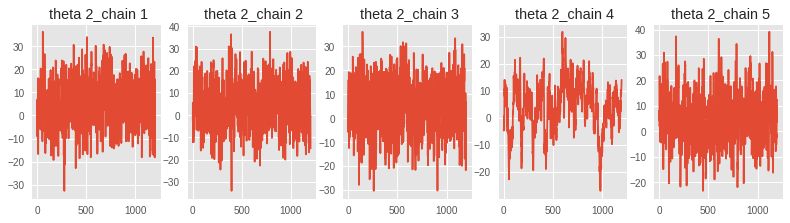

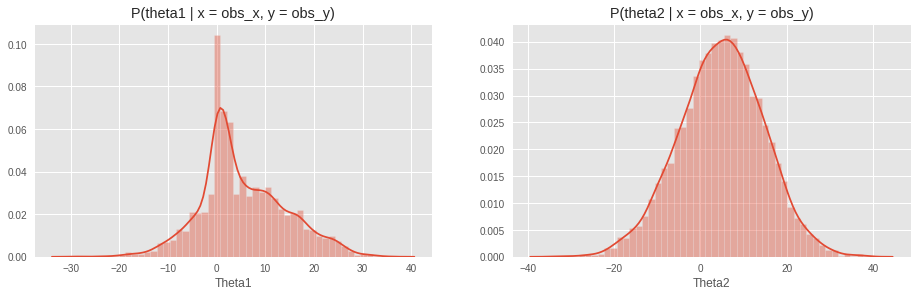

In [419]:
analyze_hmc(conditioned_model,obs_y,obs_x,dist.Normal(5,10),1200, 400, 5)

According to results (particularly checking `n_eff`, `r_hat` and plots), we have more consistent result for theta2 this time. But it is worth to point out that theta values have higher standard deviation this time.

c. Plot the most reliable posterior distributions, according to convergence checks on the traces.

- After trying different prior distributions like Normal, Exponential, Half-Cauchy and Inverse-Gamma, Exponential distribution gave the best result according to `n_eff`, `r_hat` and plots. you can find the results belove. Of course theta1 and theta2 may have different prior distribution but for simplicity I assume that they have same distribution with same parameters. But one can easily set a new parameter to assign them different distributions and parameters






Keys: dict_keys(['theta1', 'theta2']) 

Summary of MCMC:


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    theta1      0.52      0.51      0.37      0.00      1.19   1064.44      1.00
    theta2      0.50      0.50      0.34      0.00      1.15   1586.70      1.00

Number of divergences: 0
Shape of chain_1 torch.Size([5, 1200]) and chain_2 torch.Size([5, 1200])

expected theta1 = 0.517747163772583
expected theta2 = 0.49821317195892334


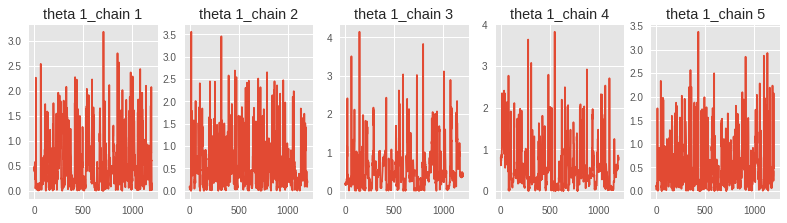

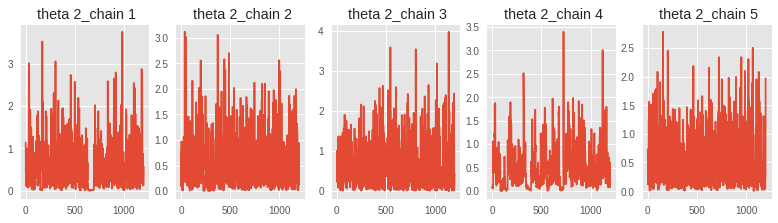

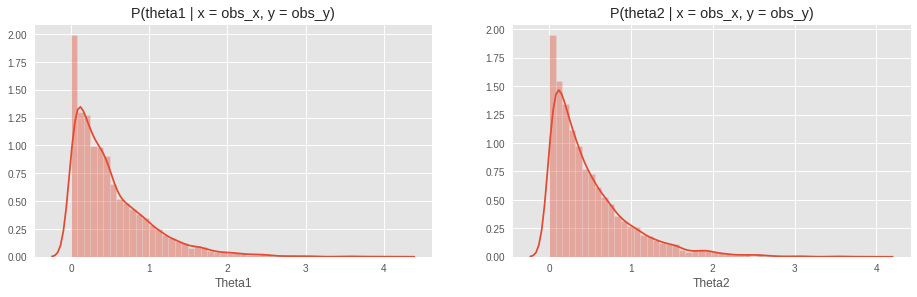

In [418]:
analyze_hmc(conditioned_model,obs_y,obs_x,dist.Exponential(2),1200, 400, 5)

### Exercise 2

A bivariate Gibbs sampler for a vector $x=(x_1,x_2)$ draws iteratively from the posterior conditional distributions in the following way:
- choose a starting value $p(x_1|x_2^{(0)})$
- for each iteration $i$:
    - draw $x_2(i)$ from $p(x_2|x_1^{(i-1)})$
    - draw $x_1(i)$ from $p(x_1|x_2^{(i)})$

a. Supposing that samples are drawn from a bivariate normal distribution

$$
{x_1 \choose x_2} \sim \mathcal{N} \Bigg[ {0 \choose 0} , \begin{pmatrix} 1 & \rho \\ \rho & 1 \end{pmatrix} \Bigg],
$$
    implement a Gibbs sampler for $x$ which takes as inputs the number of iterations `iters` and the number of warmup draws `warmup`.

b. Use your implementation of Gibbs sampler to infer the parameters $\theta=(\theta_1,\theta_2)$ from **Exercise 1**.